In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import json
import os
from pandas.io.json import json_normalize
from functools import partial
from pdb import set_trace

from datetime import datetime, timedelta
import urllib.request

from fastai.vision.all import *
from fastai.tabular.all import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
x = torch.linspace(1,30,30).view(3,-1)
x

tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15., 16., 17., 18., 19., 20.],
        [21., 22., 23., 24., 25., 26., 27., 28., 29., 30.]])

In [3]:
# Make a mask of values that will get swapped
mask = torch.rand(x.size()) > (1 - 0.2)
mask

tensor([[False, False, False, False,  True,  True, False, False, False, False],
        [False, False,  True,  True,  True, False,  True, False, False, False],
        [False, False, False,  True,  True, False, False, False, False, False]])

In [4]:
# For each element, sample a number between 0 and batchSize
rowSelector = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
rowSelector

tensor([[1, 1, 2, 1, 1, 0, 1, 1, 1, 0],
        [1, 2, 1, 0, 0, 2, 1, 0, 1, 1],
        [0, 0, 0, 2, 0, 2, 0, 0, 1, 0]])

In [5]:
# Then for each element, 
res = rowSelector * mask * x.size(1)
res

tensor([[ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
        [ 0,  0, 10,  0,  0,  0, 10,  0,  0,  0],
        [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0]])

In [6]:
idx = torch.arange(x.nelement()) + res.view(-1)
idx

tensor([ 0,  1,  2,  3, 14,  5,  6,  7,  8,  9, 10, 11, 22, 13, 14, 15, 26, 17,
        18, 19, 20, 21, 22, 43, 24, 25, 26, 27, 28, 29])

In [7]:
idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
idx

tensor([ 0,  1,  2,  3, 14,  5,  6,  7,  8,  9, 10, 11, 22, 13, 14, 15, 26, 17,
        18, 19, 20, 21, 22, 13, 24, 25, 26, 27, 28, 29])

In [8]:
x.flatten()[idx].view(x.size())

tensor([[ 1.,  2.,  3.,  4., 15.,  6.,  7.,  8.,  9., 10.],
        [11., 12., 23., 14., 15., 16., 27., 18., 19., 20.],
        [21., 22., 23., 14., 25., 26., 27., 28., 29., 30.]])

In [9]:
import platform
sys = platform.system()

In [10]:
url = URLs.MNIST
path = untar_data(url)

In [11]:
class PILImageBWNoised(PILImageBW): pass
class TensorImageBWNoised(TensorImageBW): pass
PILImageBWNoised._tensor_cls = TensorImageBWNoised

class PILImageTarget(PILImageBW): pass
class TensorImageTarget(TensorImageBW): pass
PILImageTarget._tensor_cls = TensorImageTarget

@Normalize
def encodes(self, to:TensorImageTarget): return to

class AddNoiseTransform(Transform):
    "Add noise to image"
    order = 11
    def __init__(self, noise_factor=0.5): self.noise_factor=noise_factor
    def encodes(self, o:TensorImageBWNoised): return (o + (self.noise_factor * torch.randn(*o.shape).to(o.device))).clamp(0,1)

mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBWNoised), CategoryBlock, ImageBlock(cls=PILImageTarget)), 
                 get_items=get_image_files,
                 get_x= [noop, parent_label],
                 splitter=GrandparentSplitter(train_name='training' if url == URLs.MNIST else 'train', valid_name='testing' if url == URLs.MNIST else 'valid'),
                 batch_tfms=[AddNoiseTransform(.3), Normalize()],
                 n_inp=2)

In [12]:
dls = mnist.dataloaders(path, num_workers=0 if sys != 'Linux' else 8, bs=4096)

In [13]:
class UnFlatten(Module):
    def __init__(self, size): self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.size, 7, 7)
    
class Swish(Module):
    def forward(self, x): return x * torch.sigmoid(x)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, dropout=.01):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        kernel_size = 2
        self.encoder = nn.Sequential(
            ResBlock(1, 1, 16, act_cls=Swish),
            nn.MaxPool2d(2, 2),
            ResBlock(1, 16, 4, act_cls=Swish),
            nn.MaxPool2d(2, 2),
            Flatten()
        )
        
        self.emb = Embedding(10, emb_sz_rule(10))
        
        h_dim = h_dim + emb_sz_rule(10)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim-emb_sz_rule(10))
        self.fc4 = nn.Linear(emb_sz_rule(10), 7*7)
        
        self.decoder = nn.Sequential(
            ResBlock(1, 5, 8, ks=1, act_cls=Swish),
            nn.Dropout2d(),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Swish),
            nn.Dropout2d(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Dropout2d(),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.cuda.HalfTensor(*mu.size()).normal_()
#         esp = torch.randn(*mu.size()).to(mu.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, num):
        h = self.encoder(x)
        e = self.emb(num)
        h = torch.cat([h,e], dim=1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z, num):
        z = self.fc3(z)
        z = z.view(z.size(0), 4, 7, 7)
        
        num = self.fc4(self.emb(num)).view(z.size(0), 1, 7, 7)
        z = torch.cat([z, num], dim=1)
        
        z = self.decoder(z)
        return z

    def forward(self, x, num):
        num = num.long()
        z, mu, logvar = self.encode(x, num)
        z = self.decode(z, num)
        return z, mu, logvar
    
    def inference(self, n=1, c=None):

        batch_size = n
        z = torch.randn([batch_size, self.latent_size])

        recon_x = self.decoder(z, c)

        return recon_x
    
model = VAE(image_channels=1, h_dim=196, z_dim=128, dropout=.1).cuda()

In [7]:
onebatch = dls.one_batch()
img, num, targets_img = onebatch

In [8]:
explode_types(onebatch)

{tuple: [__main__.TensorImageBWNoised,
  fastai.torch_core.TensorCategory,
  __main__.TensorImageTarget]}

In [9]:
# %debug
with torch.no_grad():
    res = model(img, num)

In [10]:
class BCEMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        self.preds.append(F.binary_cross_entropy(to_detach(learn.pred[0]), to_detach(learn.y), reduction='sum'))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class KLDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        pred, mu, logvar = to_detach(learn.pred)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.preds.append(KLD)
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class MUMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        pred, mu, logvar = to_detach(learn.pred)
        self.preds.append(mu.mean())
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class StdMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        pred, mu, logvar = to_detach(learn.pred)
        self.preds.append((logvar.exp_() ** .5).mean())
    @property
    def value(self):
        return np.array(self.preds).mean()

def loss_fn(output, x):
    recon_x, mu, logvar, kl_weight = output
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + (kl_weight * KLD)

In [11]:
@typedispatch
def show_results(x:(TensorImageBWNoised, TensorCategory), y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    set_trace()
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


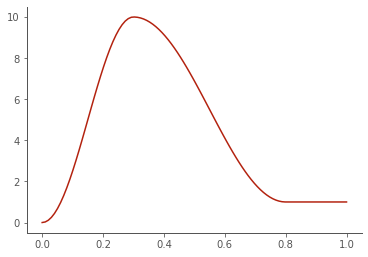

In [12]:
f = combine_scheds([.3, .5, .2], [SchedCos(0,10), SchedCos(10,1), SchedNo(1,1)])
p = torch.linspace(0.,1,100)
plt.plot(p,[f(o) for o in p])

In [13]:
@typedispatch
def wandb_process(x:tuple, y:TensorImageTarget, samples, outs):
    img_input, category = x
    img_preds, mu, logvar = outs
    
    img_inputs = []
    for img, cat,target,pred in zip(img_input, category, y, img_preds):
        i = torch.cat([img.clamp(0,1), target, pred], dim=2).squeeze(0)
        
        img_inputs += [wandb.Image(i)]
    
    return {"Predictions": img_inputs}

In [22]:
import wandb
from fastai.callback.wandb import *

wandb.init(project='VAE-MNIST')

scheds = {'kl_weight': f }

class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        kl[0] = self.opt.hypers[0]['kl_weight']
        self.learn.pred = self.learn.pred + (kl,)
    def after_batch(self):
        pred, mu, logvar, _ = self.learn.pred
        self.learn.pred = (pred, mu, logvar)

class WandbCallbackCustom(WandbCallback):
    def log_predictions(self, preds):
        inp,preds,targs,out = preds
        tolog = wandb_process(inp, targs, inp, preds)
        
#         num = 10 if url == URLs.MNIST else 2
#         fig, axes = plt.subplots(ncols=num, nrows=10, figsize=(19,19))
        
#         i = 0
#         with torch.no_grad():
#             self.model.eval()
#             for row in axes:
#                 z = torch.empty([num,128]).normal_().cuda()
#                 img = self.model.decode(z.half(), torch.Tensor(range(num)).long().cuda()).detach().cpu().float()
#                 for ax in row:
#                     ax.imshow(img[i%num][0], cmap='Greys')
#                     ax.axis('off')
#                     ax.set_title(str(i%num))
#                     i += 1
#             self.model.train()
        
        
#         tolog['Samples'] = [wandb.Image(fig)]
        
        wandb.log(tolog, step=self._wandb_step)
        
def prepare_preds(preds):
    inp,preds,targs,out = preds
    return inp, targs, inp, preds


cbs=[ParamScheduler(scheds), SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True)]
cbs += [AnnealedLossCallback()]
cbs += [WandbCallbackCustom(reorder=False, n_preds=20)]

In [23]:
model = VAE(image_channels=1, h_dim=196, z_dim=128).cuda()

learn = Learner(dls, model, cbs=cbs, loss_func=loss_fn, metrics=[BCEMetric(), KLDMetric(), MUMetric(), StdMetric()])
learn = learn.to_fp16()

In [24]:
learn.fit_one_cycle(200)

# learn.save(datetime.now().strftime('%Y-%m-%d %Hh%M.%S') + '.model')

epoch,train_loss,valid_loss,bce,kld,mu,std,time
0,2551188.000000,1940597.375000,1756636.4,26377.828,0.022355616,1.0055068,00:23
1,2554528.500000,1971957.375000,1769560.1,66098.04,0.031434197,1.0180774,00:21
2,2555170.000000,2023479.750000,1787258.5,96098.125,0.03588161,1.027765,00:24
3,2556306.500000,2027606.375000,1795675.5,106653.02,0.0374991,1.0314348,00:23
4,2545117.000000,2028500.625000,1798846.0,115492.26,0.040264916,1.0344174,00:24
5,2530002.750000,2033235.000000,1799111.2,124404.875,0.043538444,1.0356818,00:25
6,2512746.500000,2037256.750000,1797392.2,131886.12,0.046455745,1.0335414,00:23
7,2494612.750000,2033698.875000,1794051.6,136186.66,0.0481489,1.0267199,00:25
8,2477611.500000,2021000.625000,1790058.4,135844.52,0.04699042,1.0153166,00:25
9,2463241.750000,2006069.625000,1786174.1,132058.19,0.045813262,1.001674,00:24


wandb: Adding directory to artifact (/tmp/tmpt7nu251k)... Done. 0.0s


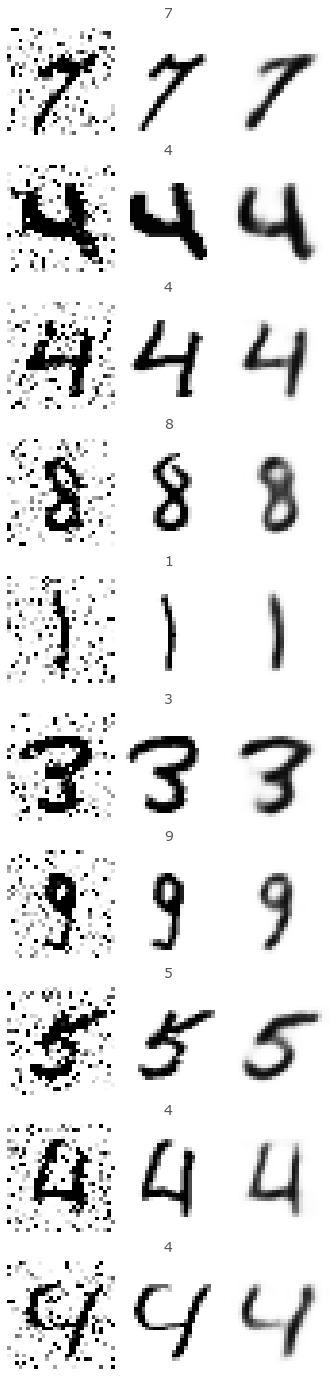

In [44]:
b = learn.dls[0].one_batch()
input_img, nums, targets = to_detach(b)
preds, targs = learn.get_preds(dl=[b])
imgs, _, _ = preds

_, axes = plt.subplots(ncols=1, nrows=10, constrained_layout=True, figsize=(10, 19))
i = 0
for a in axes:
    a.set_title(nums[i].cpu().item())
    img = torch.cat([input_img.clamp(0,1), targs, imgs], dim=3)[i].squeeze(0).cpu()
    a.imshow(img, cmap='Greys')
    a.axis('off')
    i = i + 1

In [15]:
class MCDropoutCallback(Callback):
    def before_validate(self):
        for x in [m for m in flatten_model(self.model) if 'dropout' in m.__class__.__name__.lower()]:
            x.train()
    
    def after_validate(self):
        for x in [m for m in flatten_model(self.model) if 'dropout' in m.__class__.__name__.lower()]:
            x.eval()

[Dropout2d(p=0.01, inplace=False),
 Dropout2d(p=0.01, inplace=False),
 Dropout2d(p=0.01, inplace=False)]

In [48]:
all_imgs = []
b = learn.dls[0].one_batch()
input_img, nums, targets = to_detach(b)

with torch.no_grad():
    for i in range(10):
        preds, targs = learn.get_preds(dl=[b], cbs=[MCDropoutCallback()])
        imgs, _, _ = preds
        all_imgs += [imgs]
    
all_imgs = np.stack(all_imgs)
all_imgs.shape

(10, 128, 1, 28, 28)

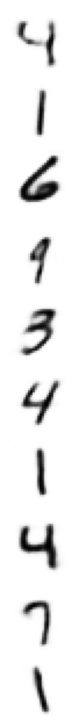

In [50]:
_, axes = plt.subplots(ncols=1, nrows=10, constrained_layout=True, figsize=(10, 10))

i = 0
for a in axes:
    img = all_imgs.mean(axis=0)[i].squeeze(0)
    a.imshow(img, cmap='Greys')
    a.axis('off')
    i = i + 1

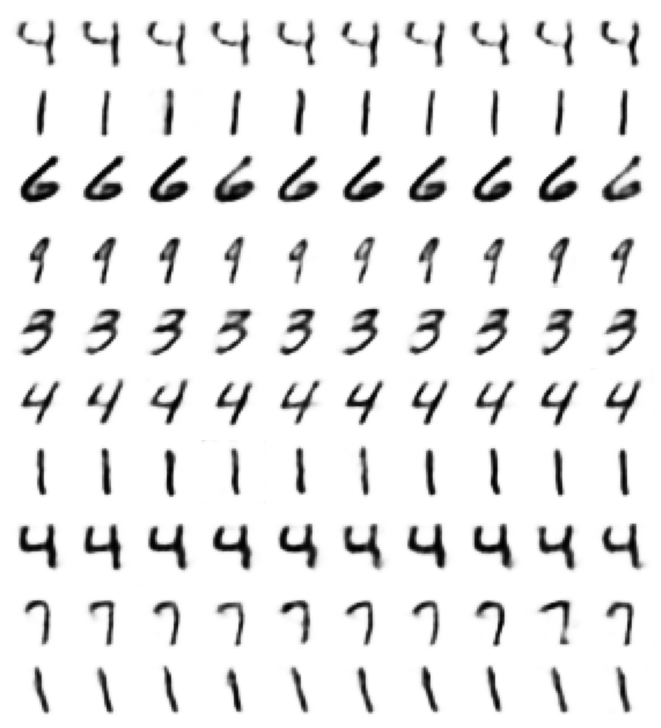

In [51]:
_, axes = plt.subplots(ncols=1, nrows=10, constrained_layout=True, figsize=(10, 10))
i = 0
for a in axes:
    img = np.concatenate(all_imgs[:,i], axis=2).squeeze(0)
    a.imshow(img, cmap='Greys')
    a.axis('off')
    i = i + 1

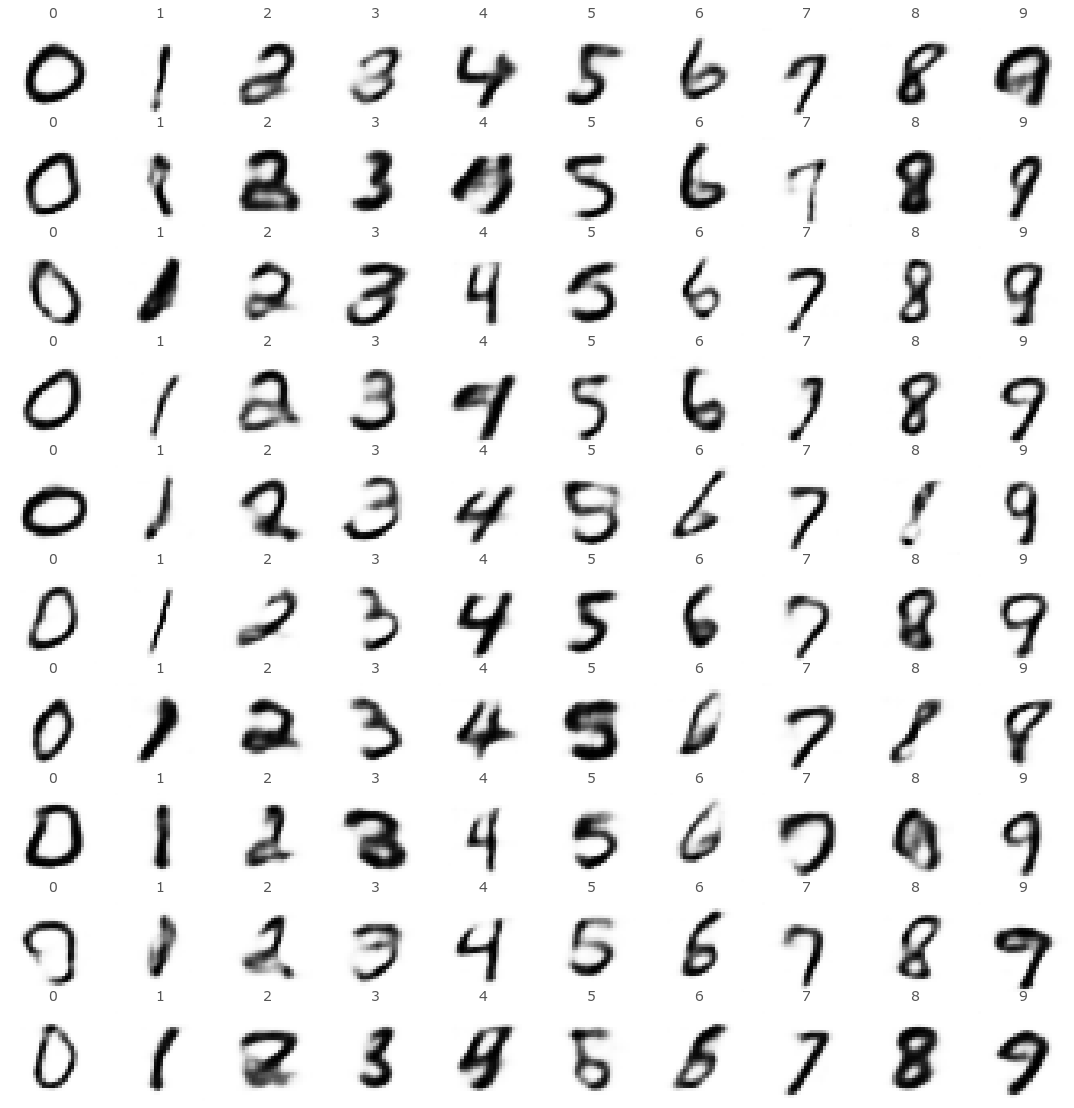

In [52]:
# %debug
num = 10 if url == URLs.MNIST else 2
_, axes = plt.subplots(ncols=num, nrows=10, figsize=(19,19))
learn.model.eval()
i = 0
with torch.no_grad():
    for row in axes:
        z = torch.empty([num,128]).normal_().cuda()
        img = learn.model.decode(z, torch.Tensor(range(num)).long().cuda()).detach().cpu()
        for ax in row:
            ax.imshow(img[i%num][0], cmap='Greys')
            ax.axis('off')
            ax.set_title(str(i%num))
            i += 1